In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

Matplotlib is building the font cache; this may take a moment.


### 1. 임베딩 벡터 만들기

In [3]:
# 데이터 불러오기
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [4]:
from konlpy.tag import Okt

In [5]:
# 불러온 데이터 토크나이징
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [6]:
from gensim.models import Word2Vec

In [7]:
# 임베딩 모델 
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.8924918174743652),
 ('다큐멘터리', 0.8555873036384583),
 ('드라마', 0.8127234578132629),
 ('영화로', 0.7853426933288574),
 ('형식', 0.7829360365867615),
 ('스토리', 0.7791306376457214),
 ('소재', 0.7756350636482239),
 ('코미디', 0.7723138332366943),
 ('버자이너', 0.7722804546356201),
 ('감동', 0.7688953280448914)]

### 2. 예술영화와 일반영화에서 등장하는 단어들로 WEAT스코어 구하기

In [8]:
# 코사인 유사도와 위트 스코어

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [9]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [10]:
# 예술영화와 일반영화 줄거리 불러오기
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [11]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.cluster import KMeans

In [12]:
# 리스트 반환하는 토크나이징 함수 생성
def read_token_list(file_name):
    
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:  # 명사만 추출
                    result.append(word[0])
    return result

In [13]:
# 토크나이징 후 리스트형태로 저장
art_list = read_token_list(art_txt)
gen_list = read_token_list(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [14]:
# 예술영화 토큰과 일반영화 대표단어
art_tokens = [word for word in art_list if word in model.wv]
gen_tokens = [word for word in gen_list if word in model.wv]

In [15]:
# 두개 토픽별 단어 결합
lda_docs = [art_tokens, gen_tokens]

In [16]:
# 단어사전 생성
lda_dict = Dictionary(lda_docs)
lda_corp = [lda_dict.doc2bow(doc) for doc in lda_docs]

In [17]:
# LDA 모델 학습 - 2개 토픽
lda = LdaModel(corpus=lda_corp,
    num_topics=2,  # 원하는 토픽 개수
    id2word=lda_dict,
    passes=15,
    iterations=200,
    alpha=0.01,  # 문서당 소수의 토픽만 포함하도록 설정
    eta=0.01,  # 토픽별 단어가 최대한 다르게 나오도록 설정
    random_state=42
)

In [18]:
# 주요 토픽 확인
topics = lda.print_topics(num_words=150)
for topic in topics:
    print(topic)

(0, '0.019*"그" + 0.010*"것" + 0.009*"이" + 0.008*"자신" + 0.008*"그녀" + 0.008*"영화제" + 0.007*"제" + 0.007*"수" + 0.006*"위해" + 0.006*"사람" + 0.006*"시작" + 0.005*"국제" + 0.005*"날" + 0.005*"영화" + 0.004*"집" + 0.004*"친구" + 0.004*"사랑" + 0.004*"남자" + 0.004*"알" + 0.003*"속" + 0.003*"이야기" + 0.003*"일" + 0.003*"두" + 0.003*"곳" + 0.003*"의" + 0.003*"대한" + 0.003*"서울" + 0.003*"여자" + 0.003*"살" + 0.003*"사건" + 0.003*"중" + 0.003*"남편" + 0.002*"후" + 0.002*"삶" + 0.002*"아이" + 0.002*"가족" + 0.002*"아버지" + 0.002*"말" + 0.002*"전" + 0.002*"다른" + 0.002*"은" + 0.002*"마을" + 0.002*"때" + 0.002*"시간" + 0.002*"엄마" + 0.002*"아들" + 0.002*"모든" + 0.002*"단편" + 0.002*"마음" + 0.002*"를" + 0.002*"위" + 0.002*"다시" + 0.002*"사실" + 0.002*"세계" + 0.002*"모습" + 0.002*"못" + 0.002*"작품" + 0.002*"생각" + 0.002*"통해" + 0.002*"서로" + 0.002*"더" + 0.002*"세상" + 0.002*"딸" + 0.002*"발견" + 0.002*"감독" + 0.002*"아내" + 0.002*"관계" + 0.002*"둘" + 0.002*"소녀" + 0.002*"사이" + 0.002*"안" + 0.002*"온" + 0.002*"하나" + 0.002*"우리" + 0.002*"애니메이션" + 0.002*"때문" + 0.002*"앞" + 0.001*"돈" + 0.001*

In [19]:
# 예술, 일반 영화별 단어 저장 변수
topic_words = {0: [], 1: []}

In [20]:
# 토픽별 단어 저장
for topic_id, words in lda.show_topics(num_topics=2, num_words=150, formatted=False):
    topic_words[topic_id] = [word for word, _ in words]

In [21]:
# 공통으로 등장하는 단어 삭제
art_topic_words = set(topic_words[0]) - set(topic_words[1])  # 예술 영화에서만 등장하는 단어
gen_topic_words = set(topic_words[1]) - set(topic_words[0])  # 일반 영화에서만 등장하는 단어

print("예술 영화에만 있는 단어:", list(art_topic_words))
print("일반 영화에만 있는 단어:", list(gen_topic_words))

예술 영화에만 있는 단어: ['부문', '여성', '동생', '정체', '주인공', '코', '다큐멘터리', '한국', '의도', '계속', '또', '대해', '서울', '계획', '섹스', '바로', '연출', '애니메이션', '사회']
일반 영화에만 있는 단어: ['운명', '단', '차', '명', '준비', '감정', '첫', '음악', '여인', '이름', '충격', '처음', '아빠', '지금', '과', '그린', '누구', '결심', '만난']


In [22]:
#임베딩 모델에서 단어벡터 출력하는 함수
def get_word_vectors(words, model):
    return np.array([model.wv[word] for word in words if word in model.wv])

In [23]:
# '예술'와 '일반' 단어 벡터 가져오기
X = get_word_vectors(['예술'], model)
Y = get_word_vectors(['일반'], model)

# 기준 단어 (예술 vs 일반)
A = get_word_vectors(art_topic_words, model)  # 예술 영화 기준 단어
B = get_word_vectors(gen_topic_words, model)  # 일반 영화 기준 단어

In [24]:
# WEAT 스코어 계산
weat_result = round(weat_score(X, Y, A, B), 3)
print(f"WEAT 스코어 (예술 vs 일반): {weat_result}")

WEAT 스코어 (예술 vs 일반): -2.0


In [25]:
# 속성/타겟 위치 변경 후 WEAT 스코어 계산
weat_result_rev = round(weat_score(A, B, X, Y), 3)
print(f"WEAT 스코어 (예술 vs 일반): {weat_result_rev}")

WEAT 스코어 (예술 vs 일반): -0.4440000057220459


In [26]:
np.mean(s(get_word_vectors(['예술'], model), A, B))

0.03271269

In [27]:
np.mean(s(get_word_vectors(['일반'], model), A, B))

0.049122836

In [29]:
# 단어 임베딩 평균
s_X = s(get_word_vectors(['예술'], model), A, B)
s_Y = s(get_word_vectors(['일반'], model), A, B)

In [30]:
# 단어 임베딩 표준편차
np.std(np.concatenate([s_X, s_Y], axis=0))

0.008205073

### 히스토그램으로 표현

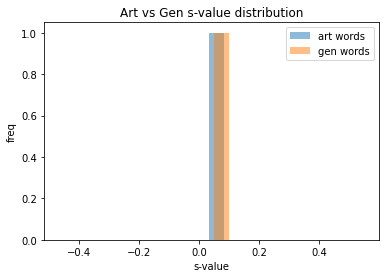

In [31]:
plt.hist(s_X, bins=20, alpha=0.5, label='art words')
plt.hist(s_Y, bins=20, alpha=0.5, label='gen words')
plt.legend()
plt.xlabel('s-value')
plt.ylabel('freq')
plt.title('Art vs Gen s-value distribution')
plt.show()

#### 2개 시놉시스 - 2개 토픽에 대한 결과 확인
 - 2개 토픽('예술'과 '일반')으로 단어 분포를 살펴본 경우 토픽별 단어 분포가 뚜렷한 차이를 보이지 않음

### 2개 시놉시스를 3개 토픽으로 표현

In [32]:
# LDA 모델 학습 - 3개 토픽
lda_3 = LdaModel(corpus=lda_corp,
    num_topics=3,  # 원하는 토픽 개수
    id2word=lda_dict,
    passes=15,
    iterations=200,
    alpha=0.01,  # 문서당 소수의 토픽만 포함하도록 설정
    eta=0.01,  # 토픽별 단어가 최대한 다르게 나오도록 설정
    random_state=42
)

# 주요 토픽 확인
topics_3 = lda_3.print_topics(num_words=150)
for topic in topics_3:
    print(topic)

(0, '0.009*"그" + 0.007*"것" + 0.006*"이" + 0.006*"위해" + 0.006*"자신" + 0.006*"수" + 0.005*"시작" + 0.005*"그녀" + 0.005*"사람" + 0.004*"영화제" + 0.004*"사랑" + 0.004*"날" + 0.004*"제" + 0.003*"속" + 0.003*"영화" + 0.003*"친구" + 0.003*"남자" + 0.003*"집" + 0.003*"국제" + 0.003*"일" + 0.002*"두" + 0.002*"의" + 0.002*"알" + 0.002*"살" + 0.002*"곳" + 0.002*"이야기" + 0.002*"마을" + 0.002*"다른" + 0.002*"사건" + 0.002*"엄마" + 0.002*"삶" + 0.002*"가족" + 0.002*"남편" + 0.002*"마음" + 0.002*"말" + 0.002*"중" + 0.002*"아이" + 0.002*"여자" + 0.002*"시간" + 0.002*"후" + 0.002*"아버지" + 0.002*"때" + 0.001*"더" + 0.001*"단편" + 0.001*"아들" + 0.001*"모든" + 0.001*"다시" + 0.001*"서로" + 0.001*"대한" + 0.001*"안" + 0.001*"전" + 0.001*"은" + 0.001*"소녀" + 0.001*"감독" + 0.001*"채" + 0.001*"서울" + 0.001*"를" + 0.001*"등" + 0.001*"생각" + 0.001*"발견" + 0.001*"세상" + 0.001*"둘" + 0.001*"향" + 0.001*"사실" + 0.001*"위" + 0.001*"온" + 0.001*"통해" + 0.001*"모습" + 0.001*"딸" + 0.001*"도시" + 0.001*"하나" + 0.001*"결혼" + 0.001*"돈" + 0.001*"때문" + 0.001*"사이" + 0.001*"과연" + 0.001*"앞" + 0.001*"구" + 0.001*"나" + 

In [33]:
# 예술, 일반 영화를 3개 토픽을 인덱스로 나누어 저장
topic_words_3 = {0: [], 1: [], 2:[]}

for topic_id, words in lda_3.show_topics(num_topics=3, num_words=150, formatted=False):
    topic_words_3[topic_id] = [word for word, _ in words]

In [34]:
# 각 토픽의 단어 집합을 생성
topic_0_words = set(topic_words_3[0])
topic_1_words = set(topic_words_3[1])
topic_2_words = set(topic_words_3[2])

# 교집합을 찾기 (두 개 이상의 토픽에서 등장하는 단어들)
common_words = (topic_0_words & topic_1_words) | (topic_1_words & topic_2_words) | (topic_2_words & topic_0_words)

# 각 토픽에서만 등장하는 단어 추출
unique_topic_0 = topic_0_words - common_words
unique_topic_1 = topic_1_words - common_words
unique_topic_2 = topic_2_words - common_words

print("토픽 0에만 있는 단어:", list(unique_topic_0))
print("토픽 1에만 있는 단어:", list(unique_topic_1))
print("토픽 2에만 있는 단어:", list(unique_topic_2))

토픽 0에만 있는 단어: ['경쟁', '갑자기', '힘', '적', '부부', '팀', '할머니']
토픽 1에만 있는 단어: ['운명', '단', '희망', '준비', '감정', '청년', '첫', '음악', '이름', '충격', '파리', '처음', '번', '프랑스', '지금', '그린', '결심', '건', '만난', '상처', '연인']
토픽 2에만 있는 단어: ['부문', '주인공', '바로', '의도', '가지', '계속', '연출']


#### 결론
- 예술영화 시놉시스에서 등장하는 단어들과 일반영화 시놉시스에서 등장하는 단어들을 비교했을 때 뚜렷한 비교는 어려움
- 토픽을 3개로 늘렸을 때에도 확인하기 어려움

### 3. 멜로로맨스, 액션, 공포 3개 시놉시스에서 등장하는 단어로 WEAT 구하기

In [35]:
# 토크나이징 후 리스트형태로 저장
romance_list = read_token_list('synopsis_romance.txt')
action_list = read_token_list('synopsis_action.txt')
horror_list = read_token_list('synopsis_horror.txt')

# 각 시놉시스별 영화 대표단어
romance_list = [word for word in romance_list if word in model.wv]
action_list = [word for word in action_list if word in model.wv]
horror_list = [word for word in horror_list if word in model.wv]

synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [36]:
# 토픽별 단어 결합
lda_docs_3 = [romance_list, action_list, horror_list]

In [37]:
# 단어사전 생성
lda_dict_3 = Dictionary(lda_docs_3)
lda_corp_3 = [lda_dict.doc2bow(doc) for doc in lda_docs_3]

In [38]:
# LDA 모델 학습 - 3개 토픽
lda_3 = LdaModel(corpus=lda_corp_3,
    num_topics=3,  # 원하는 토픽 개수
    id2word=lda_dict,
    passes=15,
    iterations=200,
    alpha=0.01,  # 문서당 소수의 토픽만 포함하도록 설정
    eta=0.01,  # 토픽별 단어가 최대한 다르게 나오도록 설정
    random_state=42
)

# 주요 토픽 확인
topics_3 = lda_3.print_topics(num_words=150)
for topic in topics_3:
    print(topic)

(0, '0.022*"그" + 0.011*"것" + 0.010*"수" + 0.009*"이" + 0.008*"시작" + 0.008*"위해" + 0.008*"사람" + 0.007*"자신" + 0.007*"집" + 0.007*"친구" + 0.007*"그녀" + 0.007*"알" + 0.006*"날" + 0.006*"사건" + 0.006*"곳" + 0.005*"공포" + 0.005*"발견" + 0.004*"속" + 0.004*"죽음" + 0.004*"마을" + 0.004*"중" + 0.003*"후" + 0.003*"일" + 0.003*"남자" + 0.003*"가족" + 0.003*"영화" + 0.003*"밤" + 0.003*"의" + 0.003*"하나" + 0.003*"사실" + 0.003*"말" + 0.003*"소녀" + 0.003*"살인" + 0.003*"전" + 0.003*"아이" + 0.002*"좀비" + 0.002*"정체" + 0.002*"비밀" + 0.002*"이야기" + 0.002*"안" + 0.002*"살" + 0.002*"딸" + 0.002*"영화제" + 0.002*"점점" + 0.002*"살해" + 0.002*"명의" + 0.002*"모든" + 0.002*"온" + 0.002*"채" + 0.002*"시간" + 0.002*"때" + 0.002*"여자" + 0.002*"제" + 0.002*"이후" + 0.002*"두" + 0.002*"다시" + 0.002*"은" + 0.002*"다른" + 0.002*"저주" + 0.002*"모두" + 0.002*"사고" + 0.002*"피" + 0.002*"아버지" + 0.002*"엄마" + 0.002*"향" + 0.002*"의문" + 0.002*"대한" + 0.002*"명" + 0.002*"계속" + 0.002*"악령" + 0.002*"더" + 0.002*"못" + 0.002*"존재" + 0.002*"일행" + 0.002*"둘" + 0.002*"위" + 0.002*"과연" + 0.002*"를" + 0.002*"모습" 

In [39]:
# 영화를 3개 토픽을 인덱스로 나누어 저장
topic_words_3 = {0: [], 1: [], 2:[]}

for topic_id, words in lda_3.show_topics(num_topics=3, num_words=150, formatted=False):
    topic_words_3[topic_id] = [word for word, _ in words]

In [40]:
# 각 토픽의 단어 집합을 생성
topic_0_words = set(topic_words_3[0])
topic_1_words = set(topic_words_3[1])
topic_2_words = set(topic_words_3[2])

# 교집합을 찾기 (두 개 이상의 토픽에서 등장하는 단어들)
common_words = (topic_0_words & topic_1_words) | (topic_1_words & topic_2_words) | (topic_2_words & topic_0_words)

# 각 토픽에서만 등장하는 단어 추출
unique_topic_0 = topic_0_words - common_words
unique_topic_1 = topic_1_words - common_words
unique_topic_2 = topic_2_words - common_words

print("토픽1에만 있는 단어:", list(unique_topic_0))
print("토픽2에만 있는 단어:", list(unique_topic_1))
print("토픽3에만 있는 단어:", list(unique_topic_2))

토픽1에만 있는 단어: ['저택', '부천', '귀신', '악령', '악몽', '학생', '저주', '차', '파티', '괴물', '기운', '갑자기', '듯', '판타스틱', '숲', '통해', '악마', '영혼', '국제', '길', '충격', '무엇', '유령', '실종', '학교', '가지', '일행', '현상', '사라', '도착', '시체', '공포', '치료', '소리', '바이러스', '자살', '병원', '좀비']
토픽2에만 있는 단어: ['테러', '존', '감옥', '형사', '단', '전쟁', '인류', '암살', '킬러', '위험', '액션', '요원', '러시아', '싸움', '무기', '전설', '가장', '정보', '범인', '힘', '현장', '적', '최고', '손', '대결', '납치', '위기', '또', '거래', '전투', '음모', '잭', '마약', '수사', '지구', '임무', '복수', '처', '작전', '건', '동료', '계획', '범죄', '보스', '세계', '조직', '인질', '정부', '경찰', '수행', '부대', '무술', '미국']
토픽3에만 있는 단어: ['여자친구', '매력', '남자친구', '방', '여성', '서로', '관계', '꿈', '회사', '애', '언니', '생활', '결혼', '카', '술', '욕망', '코', '감정', '남편', '첫', '매일', '불륜', '키', '대학', '마음', '하루', '새엄마', '혼자', '사장', '선배', '동안', '처음', '정사', '출장', '연애', '나', '보고', '간', '남', '몰래', '고백', '제안', '유혹', '이혼', '애인', '만남', '섹스', '첫사랑', '바로', '고민', '은밀', '상처', '만난', '형', '연인', '커플', '동거', '내']


In [41]:
#장르별 위트스코어 계산

A = get_word_vectors(['공포'], model)
B = get_word_vectors(['로맨스'], model)
C = get_word_vectors(['액션'], model)

X = get_word_vectors(list(topic_0_words), model) 
Y = get_word_vectors(list(topic_1_words), model)  
Z = get_word_vectors(list(topic_2_words), model)

weat_01 = weat_score(X, Y, A, B)  
weat_12 = weat_score(Y, Z, B, C)  
weat_20 = weat_score(Z, X, C, A)

In [42]:
print(f"WEAT Score (공포 vs 로맨스 영화): {round(weat_01, 3)}")
print(f"WEAT Score (로맨스 vs 액션 영화): {round(weat_12, 3)}")
print(f"WEAT Score (액션 vs 공포 영화): {round(weat_20, 3)}")

WEAT Score (공포 vs 로맨스 영화): -0.12399999797344208
WEAT Score (로맨스 vs 액션 영화): -1.0290000438690186
WEAT Score (액션 vs 공포 영화): 0.18199999630451202


In [43]:
# 단어 임베딩 평균
s_X = s(X, A, B)
s_Y = s(Y, B, C)
s_Z = s(Z, C, A)

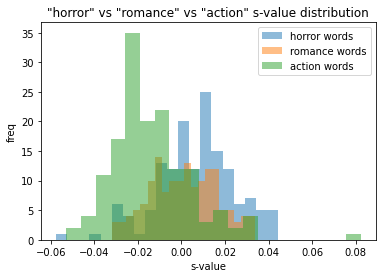

In [44]:
#히스토그램으로 표현
plt.hist(s_X, bins=20, alpha=0.5, label='horror words')
plt.hist(s_Y, bins=20, alpha=0.5, label='romance words')
plt.hist(s_Z, bins=20, alpha=0.5, label='action words')
plt.legend()
plt.xlabel('s-value')
plt.ylabel('freq')
plt.title('"horror" vs "romance" vs "action" s-value distribution')
plt.show()

In [45]:
import seaborn as sns

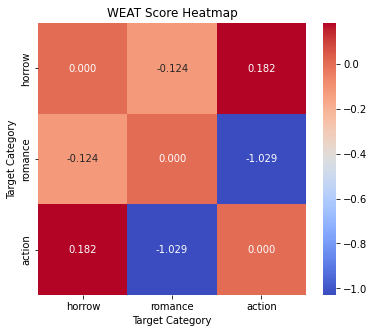

In [46]:
# 히트맵으로 표현
weat_scores = np.array([
    [0, weat_01, weat_20],  # 공포 vs 로맨스, 공포 vs 액션
    [weat_01, 0, weat_12],  # 로맨스 vs 공포, 로맨스 vs 액션
    [weat_20, weat_12, 0]   # 액션 vs 공포, 액션 vs 로맨스
])

# 토픽 라벨 지정
labels = ['horrow', 'romance', 'action']

# 히트맵 생성
plt.figure(figsize=(6, 5))
sns.heatmap(weat_scores, annot=True, fmt=".3f", cmap="coolwarm", xticklabels=labels, yticklabels=labels)

# 그래프 설정
plt.title("WEAT Score Heatmap")
plt.xlabel("Target Category")
plt.ylabel("Target Category")
plt.show()

#### 결론
- 타겟과 속성을 바꾸니 어느 정도의 관계를 보였음
- 공포는 로맨스, 액션 모두와 조금의 편향을 보임
- 로맨스와 액션은 인간과 반대 편향을 가짐